# LSTM recurrent neural networks learn formal languages

<a target="_blank" href="https://colab.research.google.com/github/jaspock/me/blob/main/docs/materials/transformers/assets/notebooks/lstm.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
<a href="http://dlsi.ua.es/~japerez/"><img src="https://img.shields.io/badge/Universitat-d'Alacant-5b7c99" style="margin-left:10px"></a>

Notebook and code written by Juan Antonio Pérez in 2024. 

This notebook implements a LSTM-based RNN (recurrent neural network) and trains it to learn simple languages following the classical article "[LSTM recurrent networks learn simple context-free and context-sensitive languages](https://www.researchgate.net/publication/3303030_LSTM_recurrent_networks_learn_simple_context-free_and_context-sensitive_languages)" by Gers and Schmidhuber (2001). The implementation follows the notation in the book "[Speech and Language Processing](https://web.stanford.edu/~jurafsky/slp3/)" (3rd edition) by Jurafsky and Martin. You are supposed to know the basics of PyTorch and the math behind the models, so this notebook will not explain all the details. The main goal is to illustrate the inner workings of LSTM RNNs and the interpretability of their mechanics.

*Formal languages*, as defined in computer science and linguistics in the second half of the 20th century, are sets of strings built by using specific sets of symbols and rules, distinguishing them from the organically evolved natural languages. They are structured within a taxonomy known as the Chomsky hierarchy, which categorizes these languages into four levels based on complexity based on the computational models needed to parse and recognize them: *regular languages* (the simplest ones) are recognized by finite automata, *context-free languages* require pushdown automata, *context-sensitive languages* demand linear-bounded automata, and *recursively enumerable languages* can be recognized by Turing machines. You are probably familiar with the first level of the hierarchy, as it is the one used to define regular expressions (such as `ab*c+`), and maybe the second one, as it is the one used to define context-free grammars, which are the basis for the syntax of most programming languages.

The LSTM RNNs have been shown to learn the first three levels of the Chomsky hierarchy, and this notebook will illustrate how they can do so. Basing our analysis on these relatively simple languages will ease the understanding of the inner mechanics of the models. Similarly to language models, our networks will be trained to predict the next symbol in a sequence. Adapting the code to other tasks such as time-series prediction or sequence classification is straightforward.

If your learning is being supervised by a teacher, follow the additional instructions that you may have received. Although you may use a GPU environment to execute the code, the computational requirements for the default settings are so low that you can probably run it on CPU.

In [1]:
%%capture
%pip install torch numpy matplotlib

In [2]:
import os
# set before importing pytorch to avoid all non-deterministic operations on GPU
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

import random
import numpy as np
import torch

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.use_deterministic_algorithms(True)
    
set_seed(44)  # to ensure reproducibility

## Model definition

We will define two classes for the model: one for a recurrent layer and another one for the whole model. The whole model will contain the input embeddings, one or more recurrent layers, and the prediction layer. 

### A single LSTM layer

A single LSTM layer is made of a number of LSTM units (or cells) defined in the `hidden_size` parameter. The input to the layer is a mini-batch of vectors of dimension `input_size`, and the output is a mini-batch of vectors of dimension `hidden_size`. The notation in the code follows the one in the book by Jurafsky and Martin, so it is recommended to have the corresponding book chapter at hand. Each object of the class stores the outputs of the units (`self.h_t`) and the hidden cell states (`self.c_t`) for the previous time step, as this is necessary to compute the forward pass in the next time step. Note that as the input is a mini-batch, mini-batches of vectors are stored in `self.h_t` and `self.c_t`.

The `forward` function returns the outputs, the hidden states, as well as the activations of the three gates. This is not strictly necessary for an implementation of a LSTM layer, but it will be useful for debugging and understanding the inner mechanics of the model. Note how the two dimensions of `x` correspond to the mini-batch size (`B`) and the size of the vector from the previous layer (`C`), but there is no dimension for the sequence length. This is because the layer is designed to process a single time step, and the sequence is processed by iterating over the time steps. Before the first time step, the hidden states and cell states are initialized to zero.

The `*` operator in PyTorch is used for element-wise multiplication (Hadamard product), which can also be computed with `torch.mul`, whereas the `@` operator (equivalently, `torch.mm`) is used for matrix multiplication.

A brief comment on the terminology: the term *state* is used in traditional RNNs to refer to the activations of each hidden layer. As with other dynamic systems, the state of the system is the set of variables that describe it at a given time and which evolve over time. When introducing LSTM units, there are two types of states: on the one hand, the output of the layer that is both passed to the next layer and backpropagated to the very same layer in the next time step; and, on the other hand, the hidden activations at the heart of the LSTM unit, called the *carrousel* in the first works on LSTM. Both of them are states of the system, and both are hidden. We will try to refer to the first one as the layer *output* and the second one as the *hidden state*.

📘 *Documentation:* [torch.mm](https://pytorch.org/docs/stable/generated/torch.mul.html)

In [3]:
import torch.nn as nn

class LSTMLayer(nn.Module):
    def __init__(self, input_size, num_cells, drop_prob=0.1):
        super().__init__()
        self.input_size = input_size
        self.num_cells = num_cells
        self.W_f = nn.Linear(input_size, num_cells, bias=False)
        self.U_f = nn.Linear(num_cells, num_cells, bias=False)
        self.W_g = nn.Linear(input_size, num_cells, bias=False)
        self.U_g = nn.Linear(num_cells, num_cells, bias=False)
        self.W_i = nn.Linear(input_size, num_cells, bias=False)
        self.U_i = nn.Linear(num_cells, num_cells, bias=False)
        self.W_o = nn.Linear(input_size, num_cells, bias=False)
        self.U_o = nn.Linear(num_cells, num_cells, bias=False)
        self.dropout = nn.Dropout(drop_prob)
        self.h_t, self.c_t = None, None
        
    def forward(self, x, reset_states=False):
        B, C = x.shape  
        if reset_states or self.h_t is None or self.c_t is None:
            self.h_t = torch.zeros(self.num_cells, device=x.device)
            self.c_t = torch.zeros(self.num_cells, device=x.device)
        h_t, c_t = self.h_t, self.c_t
        f = torch.sigmoid(self.W_f(x) + self.U_f(h_t))
        k = c_t * f    
        g = torch.tanh(self.W_g(x) + self.U_g(h_t))
        i = torch.sigmoid(self.W_i(x) + self.U_i(h_t))
        j = g * i
        c_t = k + j
        o = torch.sigmoid(self.W_o(x) + self.U_o(h_t))
        h_t = o * torch.tanh(c_t)
        h_t = self.dropout(h_t)
        self.h_t, self.c_t = h_t, c_t
        return h_t, c_t, (f, i, o)

### A full LSTM-based RNN model

Our RNN has the same number of units in each layer. As a result of that, the size of the input to layer $l+1$ matches the size of the output of layer $l$ or, equivalently, the number of units in layer $l$. There is an exception for the first layer, which receives the input embeddings. Recall that the model is designed (as any other PyTorch model) to process a mini-batch of sequences. Each layer is an instance of the class `LSTMLayer` defined above.

The code in the `forward` function is straightforward, except maybe for the lines related to the tensors used to store all the states and gate activations, which are: `outputs`, `hidden_states`, `cell_states`, `input_gates`, `forget_gates`, and `output_gates`. Ignore these lines in a first reading, as these tensors are only used for debugging and visualization purposes, and focus on the rest of the code.

The input `x` has shape `(B,T)`, where `B` is the mini-batch size and `T` is the sequence length. Each value in the matrix indicate the index of the corresponding token in the sequence. These tensor is passed through the embedding layer, which returns a tensor of shape `(B,T,C')` . The loop that iterates over the time steps comes next. The representations corresponding to the current time step `t` are extracted into the variable `x_t`. Note that this leaves us with a tensor of shape `(B,1,C')`, which is a little bit uncomfortable to work with. This is why we use the `view` method to reshape it into `(B,C')`; this would have been equivalent to using `torch.squeeze`. Now, we enter into the loop that iterates over the layers and updates `x_t` with the output `h_t` of the current layer. Note that `x_t` is always of shape `(B,C')`, but `C'` corresponds to the embedding size in the first layer and to the number of cells in the previous layer in the rest of the layers. 

The output of the last layer is finally passed through a linear layer, which returns the logits for the next token in the sequence. 

In [4]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embd_size, num_cells, num_layers, output_size):
        super().__init__()
        assert num_layers >= 1, f"Invalid number of layers: {num_layers}"
        self.num_cells = num_cells
        self.num_layers = num_layers
        self.output_size = output_size
        self.embeddings = nn.Embedding(vocab_size, embd_size)
        self.lstms = nn.ModuleList([LSTMLayer(embd_size, num_cells)] 
                                   + [LSTMLayer(num_cells, num_cells) for _ in range(num_layers-1)])
        self.fc = nn.Linear(num_cells, output_size)  # prediction layer

    def forward(self, x):
        B, T = x.size()
        L = self.num_layers
        C = self.num_cells
        logits = torch.zeros(B, T, self.output_size, device=x.device)
        outputs = torch.zeros(B, T, L, C, device=x.device, requires_grad=False)
        hidden_states = torch.zeros(B, T, L, C, device=x.device, requires_grad=False)
        input_gates = torch.zeros(B, T, L, C, device=x.device, requires_grad=False)
        forget_gates = torch.zeros(B, T, L, C, device=x.device, requires_grad=False)
        output_gates = torch.zeros(B, T, L, C, device=x.device, requires_grad=False)
        x = self.embeddings(x)
        for t in range(T):
            x_t = x[:, t, :]
            Cp = x_t.shape[-1]  # C is the number of layer units, C' is the number of input features
            x_t = x_t.view(B, Cp) 
            for i, lstm in enumerate(self.lstms):
                h_t, c_t, gates = lstm(x_t, reset_states=(t==0))
                outputs[:, t, i, :] = h_t  # stores outputs for time t and i-th layer
                hidden_states[:, t, i, :] = c_t
                forget_gates[:, t, i, :] = gates[0]
                input_gates[:, t, i, :] = gates[1]
                output_gates[:, t, i, :] = gates[2]
                x_t = h_t
            logits_t = self.fc(x_t)
            logits[:, t, :] = logits_t
        return logits, outputs, hidden_states, (forget_gates, input_gates, output_gates)

## Data generation and vocabulary

Next, we define a couple of auxiliary functions. The function `fill_soft_target_anbncn` takes a string `seq` of the language $a^nb^nc^n$, a position `j` on the string and an already pre-allocated vector `soft_target` that will be filled with a probability distribution over the vocabulary for the symbol following the one at posotion `j` in `seq`. For example, the start symbol `^` may be followed by the end-of-string symbol `$` with probability 0.5 and by the symbol `a` with probability 0.5. Each symbol `a` may be similarly followed by `a` with probability 0.5 and by `b` with probability 0.5. However, once the first `b` is found, we know how many `b`'s are left after finding the first `c`. Analogously, the first `c` can be undoubtedly predicted as the last symbol in the sequence. This vector will be called the *soft target* and although it will not be used in the training process, it will be useful to determine whether the winner predition of the model is within the set of plausible continuations.

The function `generate_sequence_anbncn` generates a sequence of the language $a^nb^nc^n$ of a given length. The symbol `^` is used to mark the beginning of the sequence and the symbol `$` is used to mark the end of the sequence.

In [5]:
def fill_soft_target_anbn(seq, j, soft_target):
    if seq[j] == '^':
        soft_target[token_index['a']] = 0.5
        soft_target[token_index['$']] = 0.5
    elif seq[j] == 'a':
        soft_target[token_index['a']] = 0.5
        soft_target[token_index['b']] = 0.5
    elif seq[j] == 'b':
        soft_target[token_index[seq[j+1]]] = 1.0
    elif seq[j] == '$':
        soft_target[token_index['$']] = 1.0

def generate_sequence_anbn(n):
    return '^' + 'a' * n + 'b' * n + '$'

fill_soft_target = fill_soft_target_anbn
generate_sequence = generate_sequence_anbn

token_index = {'PAD': 0, '^': 1, 'a': 2, 'b': 3, 'c': 4, '$': 5}
index_token = {v: k for k, v in token_index.items()}
vocab_size = len(token_index)

## Batch generation

The function `make_batch` generates a mini-batch of `batch_size` sequences of different lengths of the language. If `train` is false, the mini-batch is made of sequences of increasing length starting from 0 that will be used for evaluation. If `train` is true, the length of every sequence is randomly chosen between 0 and `n_max_train`. The sequences are padded with the index of the padding symbol (`padding_idx`) to match the length of the longest sequence in the mini-batch. The function returns the input tensor, the target tensor, and the soft target tensor. The input tensor has shape `(B,T)`, the target tensor has shape `(B,T)`, and the soft target tensor has shape `(B,T,V)`, where `B` is the mini-batch size, `T` is the length of the longest sequence in the mini-batch, and `V` is the size of the vocabulary. As explained before, the soft target tensor is not used in the training process, but it will be useful for debugging and visualization purposes; unlike `target`, which only contains the index of the next symbol in the sequence, `soft_target` contains a probability distribution over the vocabulary for the next symbol in the sequence.

As usual, note how `target` is a shifted version of `input`. Note also that `soft_target` does not contain any padding symbols, but our code will not need it as this information will be taken from `input` or `target`.

In [6]:
def make_batch(batch_size, padding_idx, device, train=False, n_max_train=10):
    if not train:
        seqs = [generate_sequence(i) for i in range(batch_size)]
    else:
        seqs = [generate_sequence(random.randint(0, n_max_train+1)) for _ in range(batch_size)]
    max_len = max([len(seq) for seq in seqs])
    input = torch.zeros(batch_size, max_len, dtype=torch.long) + padding_idx
    for i, seq in enumerate(seqs):
        for j, symbol in enumerate(seq):
            input[i,j] = token_index[symbol]
    target = torch.zeros(batch_size, max_len, dtype=torch.long) + padding_idx
    soft_target = torch.zeros(batch_size, max_len, vocab_size, requires_grad=False)
    for i, seq in enumerate(seqs):
        for j, symbol in enumerate(seq[1:]):
            target[i,j] = token_index[symbol]
            fill_soft_target(seq, j, soft_target[i,j])
        last=len(seq)-1
        target[i,last] = token_index['$']
        fill_soft_target(seq, last, soft_target[i,last])
    return input, target, soft_target

## Debugging and accuracy evaluation

The function `print_sequence_and_predictions` gets one mini-batch of input sequences, the corresponding soft targets, the indices of the winner predictions as made by the model, and an index of the position in the mini-batch of the sequence of interest. It prints the sequence symbol by symbol. For each symbol, it appends the highest probability prediction made by the model and the set of plausible continuations. For example, when `a $ a/b` is printed, it means that for the current symbol `a` ,the model has predicted `$`, but `a` and `b` are the only plausible continuations.

The function `evaluate` returns the accuracy for each sequence in the input mini-batch measured as the percentage of symbols in the sequence for which the winner prediction made by the model is within the set of plausible continuations. This function extensively uses PyTorch tensor operations, so it is recommended to have the documentation at hand. The `debug` parameter is used to print the sequence and the predictions for a specific sequence in the mini-batch.

First, the indices of the winner predictions are computed by computing the argmax of the logits. Then, a mask is computed to filter out the padding symbols. The mask contains `True` values for the symbols that are not padding symbols. After that, `torch.gather` is used to extract the probability of the winner prediction from the soft target tensor. Note that the parameter `index` expects a list (actually, a vector) of indices to extract from the `soft_target` tensor. As it only contains the indices of the winner predictions, we turn each of these values into a single-value tensor with `unsqueeze(-1)`. As `torch.gather` returns a tensor of the same shape as `index`, but we have chosen only one value at each position, we use `squeeze(-1)` to remove the singleton dimension. The result is a tensor of shape `(B,T)` containing the probability of the winner prediction for each symbol in the sequence. This tensor is then turned into a boolean tensor by comparing it with zero, meaning that `True` values indicate that the winner prediction is within the set of plausible continuations as probabilities of zero will result in `False` values and any other probability will result in `True` values. The tensor `correct` contains `True` values for the symbols that are not padding symbols and for which the winner prediction is within the set of plausible continuations, and `False` otherwise. The accuracy is then computed by summing the `True` values in `correct` and dividing by the number of non-padding symbols in the sequence. 

In [7]:
def print_sequence_and_predictions(input, soft_target, indices_winner, row):
    seq = "".join([index_token[c.item()] for c in input[row] if c != token_index['PAD']])
    print(f"{seq} · ", end="")  # symbol, prediction, correct
    for i, c in enumerate(input[row]):
        if c.item() == token_index['PAD']:
            break
        symbol = index_token[c.item()]
        prediction = index_token[indices_winner[row,i].item()]
        compute = soft_target[row,i] > 0.0
        compute = compute.nonzero().squeeze(-1)
        compute = compute.tolist()
        correct = "/".join([index_token[c] for c in compute])
        print(f"{symbol} {prediction} {correct} · ", end="")
    print()

def evaluate(input, soft_target, logits, debug=None):
    indices_winner = torch.argmax(logits, dim=-1)
    padding_mask = input != token_index['PAD']  # True for elements to be considered  
    mask_winner = torch.gather(soft_target, dim=-1, index=indices_winner.unsqueeze(-1)).squeeze(-1)
    mask_winner = mask_winner.bool()
    correct = padding_mask & mask_winner
    accuracy = correct.int().sum(dim=-1) * 100.0 / padding_mask.int().sum(dim=-1)
    if debug is not None:
        print_sequence_and_predictions(input, soft_target, indices_winner, debug)
    return accuracy

## Training

The training loop proceeds as in the original paper. After a number of training steps, the model is evaluated on a mini-batch of sequences of increasing length up to the maximum value of $n$ used during training defined by `n_max_train`. Training stops when either a 100% accuracy is achieved or the maximum number of training steps is reached.

In [8]:
num_cells = 2
embd_size = 4
learning_rate = 0.05
num_layers = 1
batch_size = 10
training_steps = 2000
valid_steps = 50
n_max_train = 10  # max value of n for training sequences
n_test = n_max_train * 10  # max value of n for testing sequences

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = RNN(vocab_size=vocab_size, embd_size=embd_size, num_cells=num_cells, num_layers=num_layers, output_size=vocab_size)
model = model.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=token_index['PAD'])
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.2, total_iters=training_steps)

input_eval, target_eval, soft_target_eval = make_batch(n_max_train+1, token_index['PAD'], device=device, train=False)

model.train()
for step in range(training_steps):
    input, target, _ = make_batch(batch_size, token_index['PAD'], device=device, train=True, n_max_train=n_max_train)
    logits, _, _, _  = model(input)
    loss = criterion(logits.view(-1,logits.size(-1)), target.view(-1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    if step % valid_steps == 0:
        model.eval()
        logits, _, _, _ = model(input_eval)
        accuracy = evaluate(input_eval, soft_target_eval, logits)
        full_accuracy = accuracy >= 100.0
        if full_accuracy.all().item():
            print(f"Step [{step}], loss: {loss.item():.2f}, mean accuracy: {accuracy.mean().item():.2f}")
            print("Training done!")
            break
        model.train()
        print(f"Step [{step}], loss: {loss.item():.2f}, mean accuracy: {accuracy.mean().item():.2f}")

/home/japerez/miniconda3/envs/tpln/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Step [0], loss: 2.06, mean accuracy: 33.34
Step [50], loss: 0.56, mean accuracy: 77.09
Step [100], loss: 0.60, mean accuracy: 77.09
Step [150], loss: 0.45, mean accuracy: 100.00
Training done!


## Model evaluation

The model is then evaluated on a mini-batch of sequences of increasing length up to a maximum value of $n$ defined by `n_max_eval`. The idea is to evaluate the generalization capabilities of the model by using values of `n_max_eval` higher than `n_max_train`. The generalization range is computed as $N-1$, where $N$ is the first value of $n$ for which the model does not achieve a 100% accuracy.

In [9]:
model.eval()
input_test, target_test, soft_target_test = make_batch(n_test+1, token_index['PAD'], device=device, train=False)
logits, outputs, hidden_states, gates = model(input_test)
accuracy = evaluate(input_test, soft_target_test, logits, debug=n_max_train-1)
success_n = n_test
for n in range(0, n_test+1):
    # print(f"n = {n}, accuracy = {accuracy[n]:.2f}")
    if accuracy[n] < 100.0:
        success_n = n - 1 
        break
print(f"Training range: [0,{n_max_train}], tested range: [0,{n_test}], generalization range: [0,{success_n}]")

^aaaaaaaaabbbbbbbbb$ · ^ a a/$ · a a a/b · a a a/b · a a a/b · a a a/b · a a a/b · a a a/b · a a a/b · a a a/b · a a a/b · b b b · b b b · b b b · b b b · b b b · b b b · b b b · b b b · b $ $ · $ $ $ · 
Training range: [0,10], tested range: [0,100], generalization range: [0,100]


## Mechanics of the model

The aforementioned article presented an enlightening analysis of the inner mechanics of the LSTM RNNs, decades before current approaches such as the mechanistic interpretability. It was carried out by observing the dynamics of the gate and state evolutions as a sequence was processed. For example, in the case of $a^n b^n c^n$, after a successful training, when using a RNN with one hidden layer with two LSTM units, the network solves the problem of inferring $a^n b^n c^n$ by using a combination of two counters, instantiated separately in the two units. The carousel of one of the units increments with each appearance of the symbol $a$ and begins to decrement at the first $b$. The occurrence of a $c$ in the input triggers the closure of the input gate and the forget gate, which causes the deactivation of the counter implemented by this first unit. Similarly, the carousel of the second unit is deactivated until the first $b$ appears, at which moment the input gate opens and the forget gate momentarily closes to reset the cell state appropriately. Subsequently, the counter begins to decrement until the occurrence of the first $c$ reverses the trend of the counter and triggers a progressive increase. In summary, one of the memory blocks solves $a^n b^n$, while the other solves $b^n c^n$. The entire system functions precisely and robustly.

We can reproduce their study here just by plotting these values. Depending on your hyperparameters, your model may not behave as described above, but you can easily find models that do.

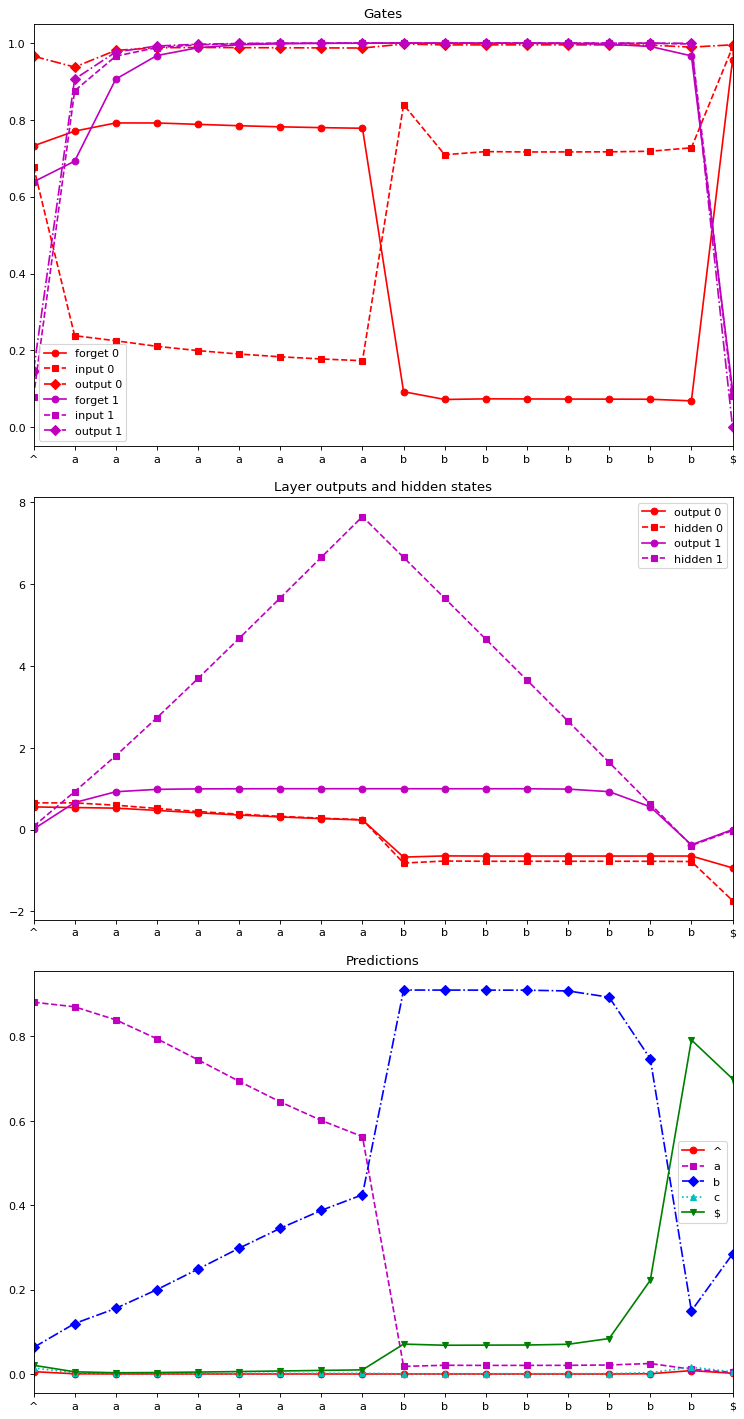

In [10]:
import matplotlib.pyplot as plt

def plot_mechanics ():
    n = 8

    color = ['r', 'm', 'b', 'c', 'g', 'y', 'k', 'orange']
    lines = ['-', '--', '-.', ':']
    markers = ['o', 's', 'D', '^', 'v', 'p', 'h', 'x']

    plt.figure(figsize=(10, 18), dpi=80)

    ax1 = plt.subplot(3, 1, 1)  # 3 rows, 1 column, first plot
    plt.tight_layout(pad=3.0)

    forget_gates, input_gates, output_gates = gates
    forget_gates_permuted = forget_gates.permute(0, 2, 3, 1)
    input_gates_permuted = input_gates.permute(0, 2, 3, 1)
    output_gates_permuted = output_gates.permute(0, 2, 3, 1)
    fg_plot = forget_gates_permuted.detach().cpu().numpy()
    ig_plot = input_gates_permuted.detach().cpu().numpy()
    og_plot = output_gates_permuted.detach().cpu().numpy()
    for i in range(fg_plot.shape[2]):
        ax1.plot(fg_plot[n, 0, i, :], label=f'forget {i}', color=color[i % len(color)], linestyle=lines[0], marker=markers[0])
        ax1.plot(ig_plot[n, 0, i, :], label=f'input {i}', color=color[i % len(color)], linestyle=lines[1], marker=markers[1])
        ax1.plot(og_plot[n, 0, i, :], label=f'output {i}', color=color[i % len(color)], linestyle=lines[2], marker=markers[2])
    x_plot = [index_token[c.item()] for c in input_test[n] if c != token_index['PAD']]
    ax1.set_xlim(0, len(x_plot)-1)
    ax1.set_xticks(range(len(x_plot)))
    ax1.set_xticklabels(x_plot)
    ax1.legend()
    ax1.set_title('Gates')

    ax2 = plt.subplot(3, 1, 2)
    output_activations = outputs.permute(0, 2, 3, 1)
    hidden_state_activations = hidden_states.permute(0, 2, 3, 1)
    o_plot = output_activations.detach().cpu().numpy()
    h_plot = hidden_state_activations.detach().cpu().numpy()
    for i in range(o_plot.shape[2]):
        ax2.plot(o_plot[n, 0, i, :], label=f'output {i}', color=color[i % len(color)], linestyle=lines[0], marker=markers[0])
        ax2.plot(h_plot[n, 0, i, :], label=f'hidden {i}', color=color[i % len(color)], linestyle=lines[1], marker=markers[1])
    ax2.set_xlim(0, len(x_plot)-1)
    ax2.set_xticks(range(len(x_plot)))
    ax2.set_xticklabels(x_plot)
    ax2.legend()
    ax2.set_title('Layer outputs and hidden states')

    ax3 = plt.subplot(3, 1, 3)
    l_plot = logits.softmax(dim=-1).detach().cpu().numpy()
    ax3.plot(l_plot[n, :, 1], label='^', color=color[0], linestyle=lines[0], marker=markers[0])
    ax3.plot(l_plot[n, :, 2], label='a', color=color[1], linestyle=lines[1], marker=markers[1])
    ax3.plot(l_plot[n, :, 3], label='b', color=color[2], linestyle=lines[2], marker=markers[2])
    ax3.plot(l_plot[n, :, 4], label='c', color=color[3], linestyle=lines[3], marker=markers[3])
    ax3.plot(l_plot[n, :, 5], label='$', color=color[4], linestyle=lines[0], marker=markers[4])
    ax3.set_xlim(0, len(x_plot)-1)
    ax3.set_xticks(range(len(x_plot)))
    ax3.set_xticklabels(x_plot)
    ax3.legend()
    ax3.set_title('Predictions')

    plt.show()

plot_mechanics()

## Exercises

If your learning path is supervised by a teacher, they may have provided you with additional instructions on how to proceed with the exercises.

✎ Analyze the time and space complexity of the forward pass of the model including some references to the code, and compare it with the time and space complexity of a transformer model.

✎ The articles that explored the capabilities of RNNs to learn formal languages detected a high sensitivity of the generalization performance to hyperparameters such as weight initialization, learning rate or number of units in the hidden layers. Evaluate the generalization capabilities of the model by training it with different hyperparameters and comparing the results. Does the model always converge to the same mechanistic solution or the same generalization capabilities?

✎ Implement the peephole connections in the LSTM cells proposed in the paper "[LSTM recurrent networks learn simple context-free and context-sensitive languages](https://www.researchgate.net/publication/3303030_LSTM_recurrent_networks_learn_simple_context-free_and_context-sensitive_languages)" by Gers and Schmidhuber (2001). Compare the results with the model without peephole connections.

✎ Explore different formal languages such as $a^nb^n$, $a^nb^mB^mA^n$ or $a^nb^nc^n$. Are they learnable by the model? Are they easier or harder to learn?

✎ Modify the model classes so that they implement a plain RNN instead of one based on LSTM cells. Train the model with the same formal languages and compare the results.

✎ Evaluate how the maximum sequence length of $n$ during training (variable `n_max_train`) affects both the convergence and generalization of the model.

✎ Relax the requirement of the model to correctly predict all the symbols in the training set to stop training. 

✎ Determine the shapes of all the tensors that are being processed in the forward pass of the model. Then run the model and print the shapes to check if your understanding is correct.

✎ The dropout layer is computed before updating `self.h_t`. Would it make sense to do it after that? How would you implement it?

✎ Implement the typical training loop in which training is stopped based on the performance on a validation set.

✎ Evaluate how the selection of the optimizer and scheduler affects the convergence of the model. 